# E5 - Grupo 5

# 0. Cargue de datos

In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [155]:
df0 = pd.read_csv('example_retail_sales.csv')
df0['ds'] = pd.to_datetime(df0['ds'])
df0.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


In [156]:
df0.tail()

,ds,y
288,2016-01-01,400928
289,2016-02-01,413554
290,2016-03-01,460093
291,2016-04-01,450935
292,2016-05-01,471421


In [157]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      293 non-null    datetime64[ns]
 1   y       293 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.7 KB


Un primer análisis general sugiere que se tiene una serie de tiempo que consta de 292 observaciones correspondientes a los registros mensuales de ventas desde enero de 1992 hasta mayo de 2016. Las fechas se encuentran en formato fecha.

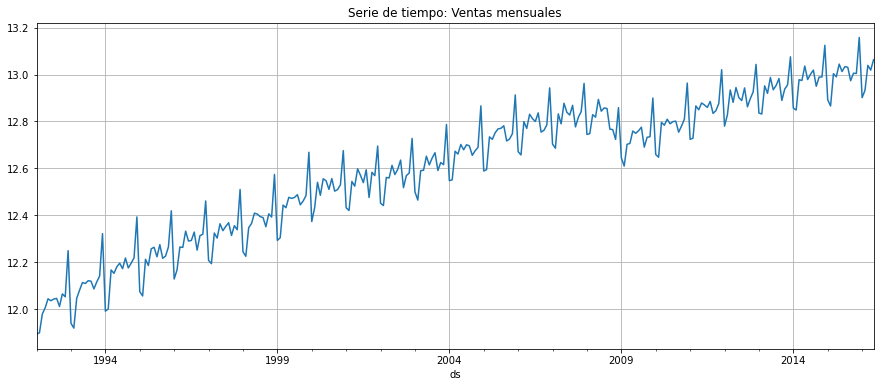

In [158]:
df1 = pd.DataFrame()
df1['ds']=df0['ds']
df1['y']=np.log(df0['y'])
df1.set_index('ds',inplace=True)
df1['y'].plot(figsize=(15,6), title='Serie de tiempo: Ventas mensuales', grid=True)

El gráfico plot de las ventas a lo largo del tiempo muestra una tendencia creciente que inicia con una pendiente y que tiene un ligero aumento de esta a partir del año 2004 y con un cambio importante a partir del año 2008 en el que se presenta una reducción de las ventas. Gráficamente parece tenerse un comportamiento estacional cada doce meses, con el mayor número mensual de ventas cada año en el mes de diciembre, esta estacionalidad se mantiene durante toda la serie de tiempo y no se ve afectada por el cambio de niveles de ventas mencionado.

# 1. Estandarización de los datos

Para estandarizar los datos de ventas, utilizamos np.log de la libraría numpy, contruyendo un nuevo dataset que procederemos a explorar.

In [160]:
df1 = pd.DataFrame()
df1['ds']=df0['ds']
df1['y']=np.log(df0['y'])
df1.head()

,ds,y
0,1992-01-01,11.893934
1,1992-02-01,11.898725
2,1992-03-01,11.978770
3,1992-04-01,12.005601
4,1992-05-01,12.043954


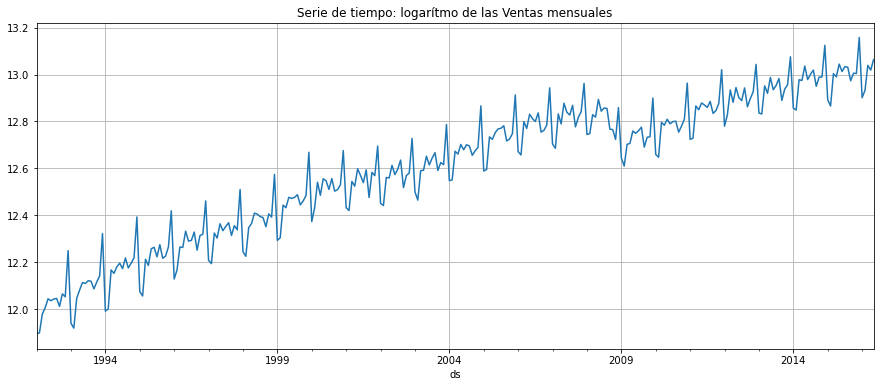

In [161]:
df2 = pd.DataFrame()
df2['ds']=df0['ds']
df2['y']=np.log(df0['y'])
df2.set_index('ds',inplace=True)
df2['y'].plot(figsize=(15,6), title='Serie de tiempo: logarítmo de las Ventas mensuales', grid=True)

La gráfica con los datos estandarizados, es decir los datos resultantes de transformar la variable ventas original con la funcion logaritmo natural, nos muestra las mismas características de estacionalidad por cada vigencia y los cambios abruptos, disminución de los niveles de ventas, a partir del año 2008.

# 2. Predicción logarítmo de ventas

In [162]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Creamos el marco de datos de la predicción que incluya los datos históricos y 6 meses adicionales de predicción 

In [163]:
m1 = Prophet()
m1.fit(df1)

future1 = m1.make_future_dataframe(periods=6, freq='m')
future1['ds']=future1['ds'] + pd.Timedelta(days=1)
future1.tail(6)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
293,2016-06-01
294,2016-07-01
295,2016-08-01
296,2016-09-01
297,2016-10-01
298,2016-11-01


El método predict nos permite asignar a cada fila del marco de datos creado un valor de predicción yhat y adicionalmente las columnas con los intervalos de incertidumbre, para cada una de los meses del marco de datos, es decir, los meses que tenemos originalmente en la serie de tiempo y los seis meses que vamos a pronosticar.

In [164]:
forecast1 = m1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
293,2016-06-01,13.055276,13.034990,13.074399
294,2016-07-01,13.056215,13.037812,13.074808
295,2016-08-01,13.076794,13.056655,13.097380
296,2016-09-01,13.009803,12.988418,13.029143
297,2016-10-01,13.048847,13.026841,13.071309
298,2016-11-01,13.053363,13.030384,13.074731


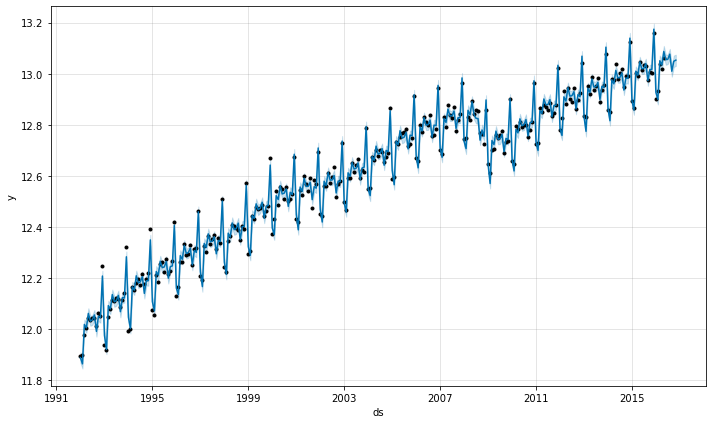

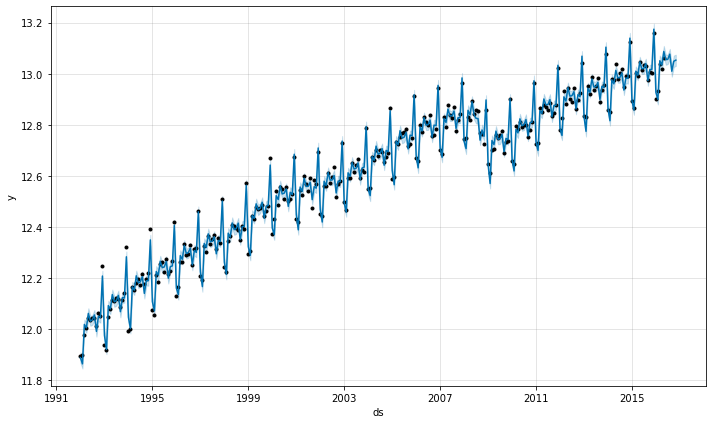

In [206]:
m1.plot(forecast1)

Graficamos el pronóstico, obteniendo visualmente al parecer un buen modelo ajustado.

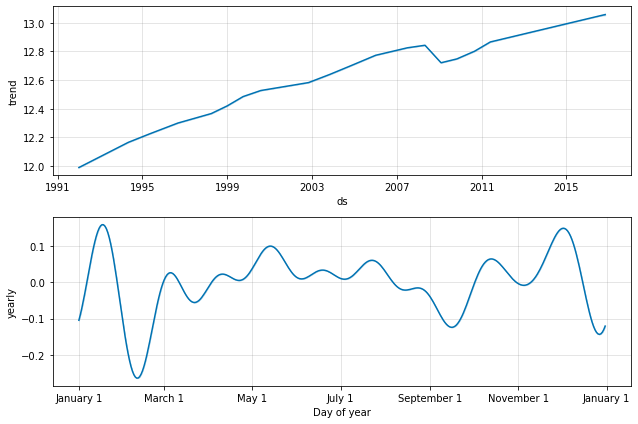

In [179]:
m1.plot_components(forecast1);

Ahora se muestran los componentes de la previsión que reflejan en la tendencia anual un cambio importante a partir de 2008 al disminuir el nivel de ventas sin dejar de tener tendencia positiva en los siguientes años. Por otra parte, el análisis de la tendencia mensual permite determinar que los niveles del logaritmo de las ventas presentan un aumento importante entre los meses de enero y febrero cayendo en el mes de marzo y posteriomente con tendencia un poco constante hasta el mes de agosto, los meses de septiembre y octubre muestran una tendencia del logaritmo de ventas a decrecer, que vuelve a ser creciente hacia los meses de noviembre y diciembre.


Ahora, la evaluación del desempeño de las predicciones usando la función cross_validation se muestra a continuación: 

In [180]:
from fbprophet.diagnostics import cross_validation

In [186]:
data_cv1 = cross_validation(m1, horizon='180 days')

INFO:fbprophet:Making 91 forecasts with cutoffs between 1993-08-30 00:00:00 and 2015-11-03 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


Para el procedimiento de validación cruzada se especifica el horizonte de pronóstico en 180 días equivalente a 6 meses, al no incluir paramteros de inicalización y de corte, por defecto se tiene que el período de entrenamiento inicial ( initial) se establece en tres veces el horizonte, es decir a partir de agosto de 1993 y el espacio entre las fechas de corte ( period) se realizan cada medio horizonte.

In [192]:
data_cv1.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1993-09-01,12.882274,12.865810,12.900707,12.086196,1993-08-30
1,1993-10-01,11.800463,11.741681,11.864361,12.115803,1993-08-30
2,1993-11-01,11.592399,11.479186,11.716575,12.141230,1993-08-30
3,1993-12-01,12.573586,12.392121,12.770796,12.321809,1993-08-30
4,1994-01-01,12.068749,11.817346,12.354042,11.991325,1993-08-30


In [193]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

performance_metrics(data_cv1)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,0.016663,0.129086,0.050086,0.004022,0.001751,0.425926
1,19 days,0.010723,0.103553,0.042436,0.003394,0.001751,0.435185
2,20 days,0.006730,0.082038,0.037053,0.002951,0.001751,0.435185
3,21 days,0.002545,0.050449,0.030494,0.002411,0.001568,0.425926
4,22 days,0.001321,0.036348,0.027152,0.002142,0.001518,0.453704
...,...,...,...,...,...,...,...
155,176 days,0.003261,0.057108,0.040758,0.003213,0.002063,0.490741
156,177 days,0.002943,0.054247,0.038710,0.003049,0.002149,0.462963
157,178 days,0.002933,0.054158,0.038814,0.003056,0.002290,0.450617
158,179 days,0.002880,0.053669,0.038145,0.003004,0.002102,0.475309


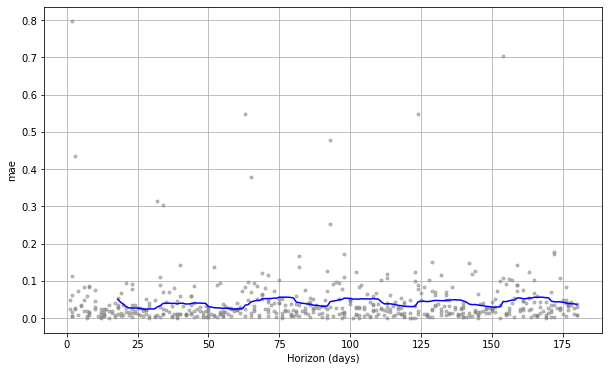

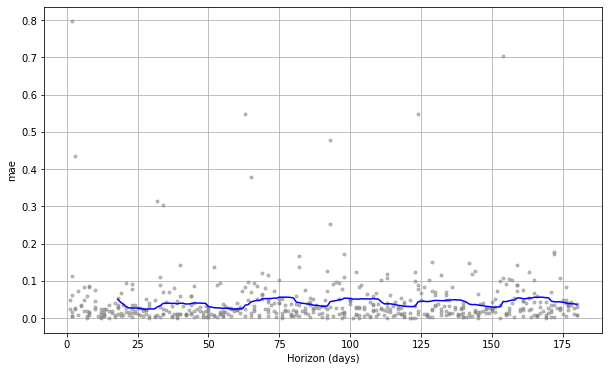

In [205]:
plot_cross_validation_metric(data_cv1, metric='mae')

La gráfica MAE, nos muestra el error absoluto medio, dado que los datos corresponden al logaritmo de las ventas, las gráficas sugieren que el error es más pequeño en el corte inical de 25 días, tendiendo a aumentar levemente a lo largo del horizonte de los 180 días evaluado. 

# 3. Predicción de ventas

In [195]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Creamos el marco de datos de la predicción que incluya los datos históricos y 6 meses adicionales de predicción 

In [196]:
m = Prophet()
m.fit(df0)

future = m.make_future_dataframe(periods=6, freq='m')
future['ds']=future['ds'] + pd.Timedelta(days=1)
future1.tail(6)
future.tail(6)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
293,2016-06-01
294,2016-07-01
295,2016-08-01
296,2016-09-01
297,2016-10-01
298,2016-11-01


El método predict nos permite asignar a cada fila del marco de datos creado un valor de predicción yhat y adicolamnete las columnas con los intervalos de incertidumbre.

In [197]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
293,2016-06-01,467140.760434,456977.439952,477849.183980
294,2016-07-01,468202.858454,457919.974430,478524.684292
295,2016-08-01,475842.593198,466421.456756,486636.305713
296,2016-09-01,456351.180618,445879.536971,466204.030531
297,2016-10-01,467599.012516,457901.164564,477429.366427
298,2016-11-01,470037.153536,459238.565854,479628.626029


Graficamos el pronóstico, obteniendo visualmente al parecer un buen modelo ajustado.

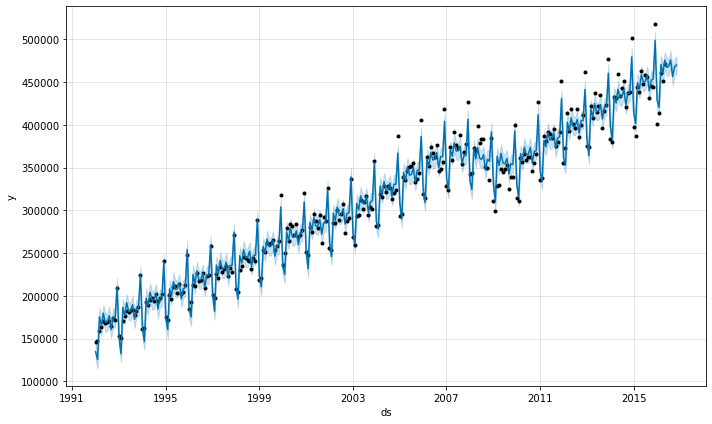

In [198]:
fig2 = m.plot(forecast)

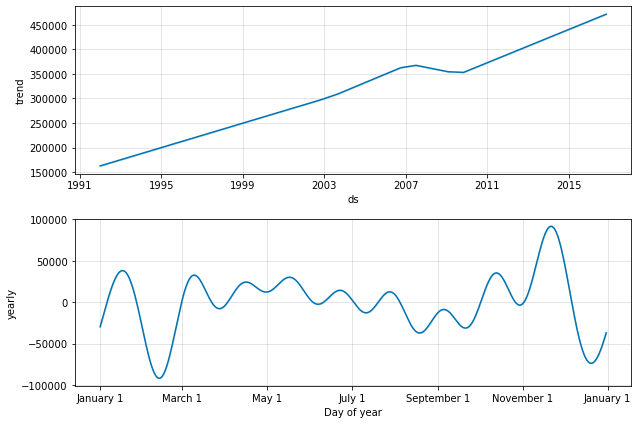

In [128]:
m.plot_components(forecast);

Ahora se muestran los componentes de la previsión que reflejan en la tendencia anual un cambio importante a partir de 2008 al disminuir el nivel de ventas sin dejar de tener tendencia positiva en los siguientes años. Por otra parte, el análisis de la tendencia mensual permite determinar que los niveles de ventas presentan una caida importante hacia los meses de febrero, recuperándose en el mes de marzo donde posteriomente con tendencia levemente decreciente, hasta el mes de septiembre, en el que la tendencia vuelve a ser positva y se logra el mayor nivel de ventas del año en el mes de diciembre.


Ahora, la evaluación del desempeño de las predicciones usando la función cross_validation se muestra a continuación: 

In [199]:
data_cv = cross_validation(m, horizon='180 days')

INFO:fbprophet:Making 91 forecasts with cutoffs between 1993-08-30 00:00:00 and 2015-11-03 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


In [200]:
performance_metrics(data_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,2.341254e+08,15301.156214,10497.061163,0.032244,0.024265,0.333333
1,19 days,1.919562e+08,13854.825346,9454.430462,0.028467,0.019175,0.361111
2,20 days,1.645982e+08,12829.582878,8814.390550,0.025976,0.018883,0.391975
3,21 days,1.734530e+08,13170.156096,9045.883809,0.026299,0.018883,0.388889
4,22 days,1.687136e+08,12988.980969,9003.471592,0.026270,0.018883,0.398148
...,...,...,...,...,...,...,...
155,176 days,3.835587e+08,19584.655480,13261.621889,0.039098,0.027684,0.416667
156,177 days,3.556624e+08,18859.014537,12651.622252,0.037246,0.027314,0.425926
157,178 days,3.531634e+08,18792.641162,12753.824441,0.037394,0.028286,0.407407
158,179 days,3.426370e+08,18510.457503,12425.614028,0.036442,0.027068,0.425926


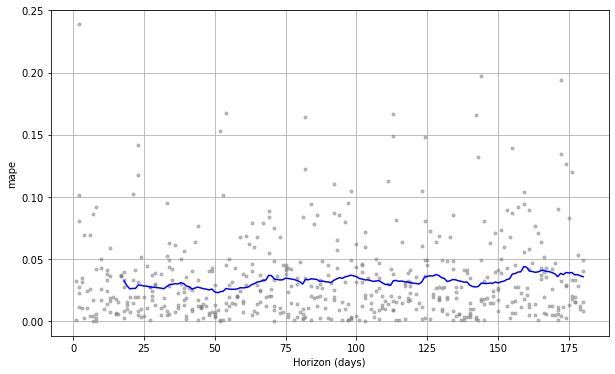

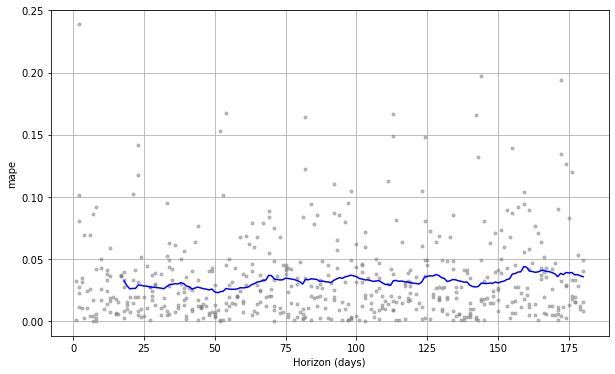

In [203]:
plot_cross_validation_metric(data_cv, metric='mape')

La gráfica MAPE, nos muestra en general el error porcentual absoluto medio, en este sentido tenemos un error del pronóstico no mayor al 5% para todo el horizonte de 180 días. Sin embargo, se identifica para este pronóstico los errores de alrededor del 3% para las predicciones de un mes en el futuro, y que los errores aumentan hasta alrededor del 5% para las predicciones que se realizan dentro de seis meses.

# 4. Conclusión


El modelo para seis meses utilizando el modelo Prophet sobre las ventas proporciona un buen pronóstico para los 6 meses en estudio. 
